In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from PIL import Image
from tensorflow.keras.utils import plot_model # type: ignore
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
import warnings
warnings.filterwarnings("ignore", message=".*CuDNN.*")
warnings.filterwarnings("ignore", message=".*cuFFT.*")
warnings.filterwarnings("ignore", message=".*cuBLAS.*")
import os
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models
from PIL import Image

2025-06-26 09:44:16.567330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750931056.808603      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750931056.875450      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_full_mnist_csv(data_path, target_path):
    """
    Loads all images and labels from an MNIST CSV file.

    Returns:
        tuple: (images (num_samples, 28, 28, 1), labels (num_samples,))
    """
    data = pd.read_csv(data_path)
    target = pd.read_csv(target_path)

    labels = target.iloc[:, 0].values
    pixels = data.iloc[:, 0:].values.astype(np.uint8)

    # Normalize and reshape
    images = pixels.reshape(-1, 28, 28, 1) / 255.0

    return images, labels


In [3]:
imgs, lbls = load_full_mnist_csv("/kaggle/input/mnist-70000-original/MNIST_data.csv", "/kaggle/input/mnist-70000-original/MNIST_target.csv")

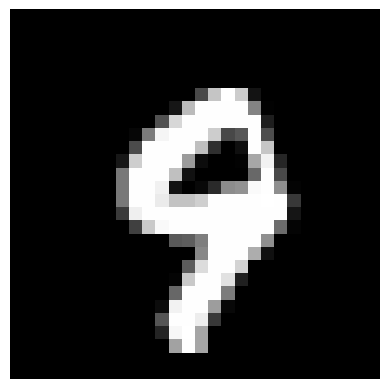

In [4]:
img = imgs[58003][:]
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

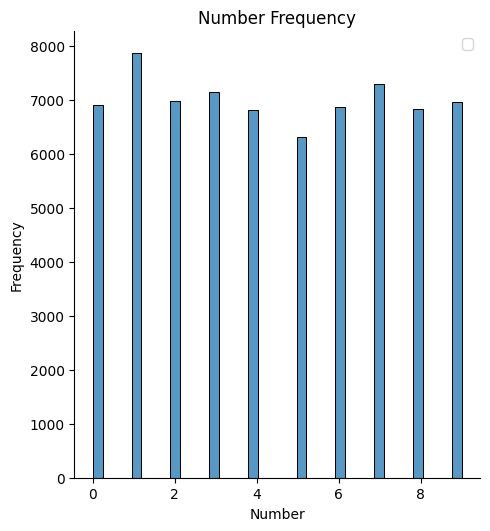

In [5]:
sns.displot(lbls)
plt.title('Number Frequency')
plt.legend()
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.show()

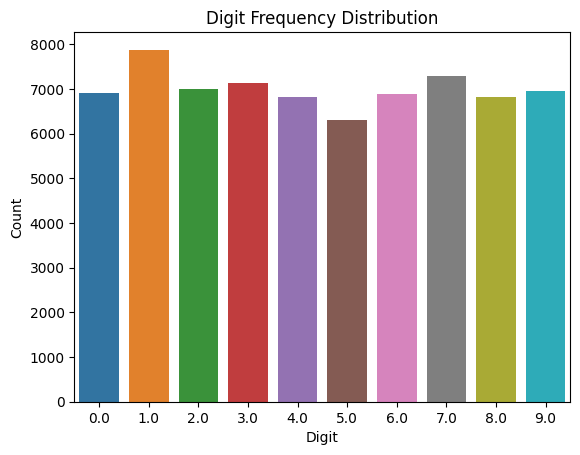

In [6]:
sns.countplot(x=lbls)
plt.title('Digit Frequency Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential()

# First Conv Block
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Second Conv Block
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()


I0000 00:00:1750931100.676778      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750931100.677411      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,418 (880.54 KB)

 Trainable params: 225,226 (879.79 KB)

 Non-trainable params: 192 (768.00 B)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(imgs, lbls, test_size=0.25, random_state=42, stratify=lbls)

In [9]:
from keras.callbacks import ModelCheckpoint
checkpoint_path = './best_mnist_model.keras'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',   # What metric to track
    verbose=1,                # Print when a new best model is saved
    save_best_only=True,      # Save only if val_accuracy improves
    mode='max'                # We want to maximize accuracy
)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/10


I0000 00:00:1750931120.055984     100 service.cc:148] XLA service 0x7c7138010100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750931120.056585     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750931120.056606     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750931120.444926     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 38/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3399 - loss: 2.7525

I0000 00:00:1750931124.777760     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7963 - loss: 0.6945
Epoch 1: val_accuracy improved from -inf to 0.97937, saving model to ./best_mnist_model.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7964 - loss: 0.6941 - val_accuracy: 0.9794 - val_loss: 0.0711
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9614 - loss: 0.1341
Epoch 2: val_accuracy improved from 0.97937 to 0.98434, saving model to ./best_mnist_model.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9614 - loss: 0.1341 - val_accuracy: 0.9843 - val_loss: 0.0544
Epoch 3/10
814/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.1017
Epoch 3: val_accuracy improved from 0.98434 to 0.98611, saving model to ./best_mnist_model.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9697 - loss: 0.1017 - val_accuracy: 0.9861 - val_loss: 0.0493
Epoch 4/10
808/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.0886
Epoch 4: val_accuracy impr

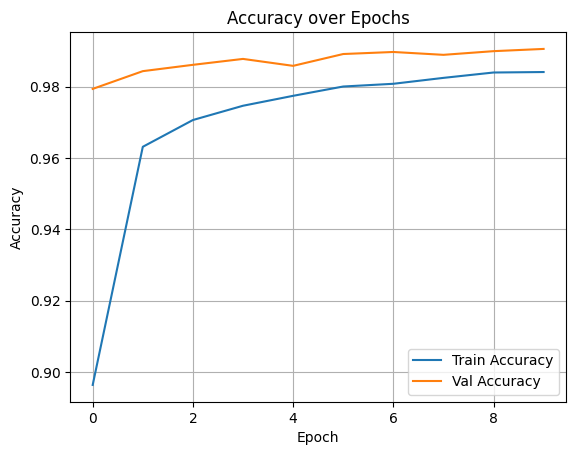

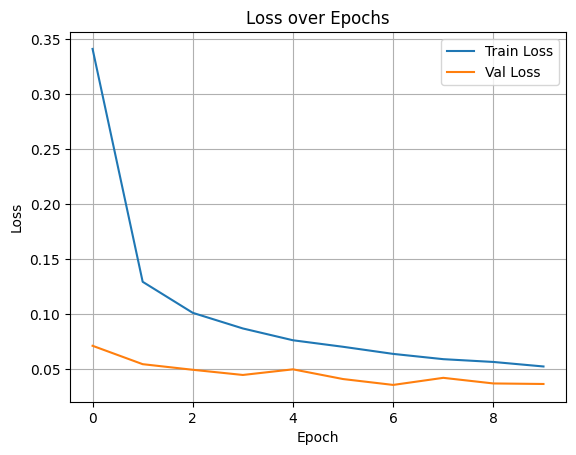

In [12]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


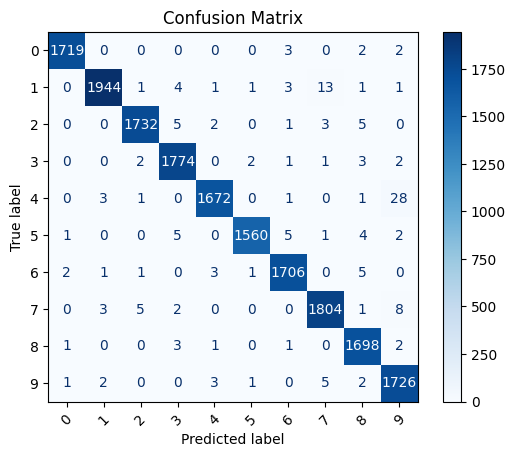

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax to class labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

# Plot
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [14]:
model.save('/kaggle/working/best_mnist_model.h5')

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint]
)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # For MNIST
])


model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


from keras.callbacks import ModelCheckpoint

checkpoint2 = ModelCheckpoint(
    './best_mnist_model2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Then add it to fit()
history2 = model2.fit(
    x_train, y_train,
    epochs=25,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint2]
)


Epoch 1/25
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8605 - loss: 0.4499
Epoch 1: val_accuracy improved from -inf to 0.98120, saving model to ./best_mnist_model2.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8606 - loss: 0.4496 - val_accuracy: 0.9812 - val_loss: 0.0601
Epoch 2/25
814/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.0686
Epoch 2: val_accuracy improved from 0.98120 to 0.98469, saving model to ./best_mnist_model2.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9795 - loss: 0.0686 - val_accuracy: 0.9847 - val_loss: 0.0451
Epoch 3/25
818/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0485
Epoch 3: val_accuracy improved from 0.98469 to 0.98646, saving model to ./best_mnist_model2.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9852 - loss: 0.0485 - val_accuracy: 0.9865 - val_loss: 0.0447
Epoch 4/25
809/821 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0346
Epoch 4: val_a

In [19]:
from tensorflow.keras.models import load_model
model = load_model('./best_mnist_model.keras')


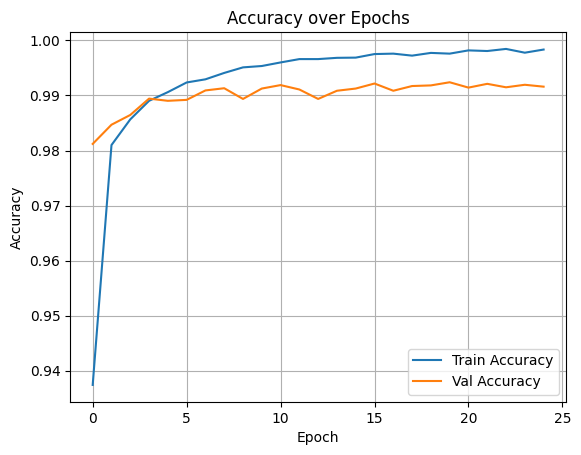

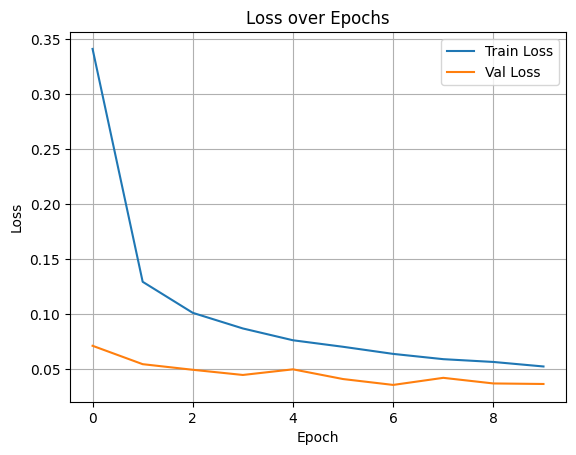

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


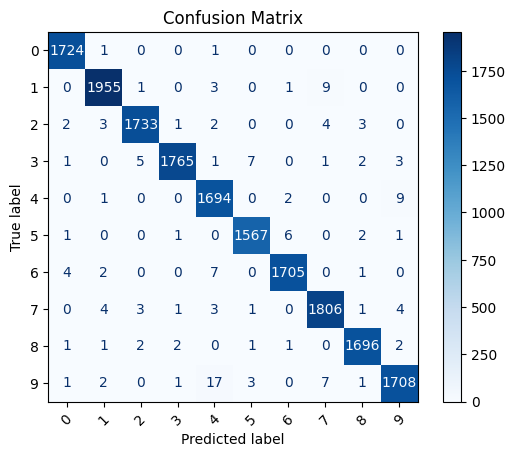

In [20]:
# Accuracy plot
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions from model
y_pred_probs = model2.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax to class labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

# Plot
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
model2.save('/kaggle/working/best_mnist_model2.h5')